In [1]:
pip install xgboost lightgbm catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 9.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 5.9 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 1.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [28]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna as op

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/train.csv'
file_key_2 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/test.csv'
file_key_3 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

In [79]:
test.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,219129,120580.0,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,-0.230126,0.220610,1.058325,-0.723363,-0.619241,-2.243711,-0.271429,2.007845,1.213534,0.282344,0.579121,0.067367,0.241708,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944,29.95
1,219130,120580.0,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,1.068183,0.483337,0.274519,-0.346514,-0.409519,-0.564673,-0.143855,1.334855,0.160901,-0.087356,-0.066264,0.441788,0.543278,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690,163.50
2,219131,120580.0,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,-1.177858,1.626352,0.601148,-0.041610,0.432748,-0.527684,-0.543665,0.043896,0.058472,0.622667,0.010671,-0.366906,-0.131527,0.086623,0.291375,0.739087,-0.543006,-0.297813,0.043699,-0.037855,16.00
3,219132,120580.0,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,2.079398,-1.225592,-0.869368,1.647638,1.138026,-0.258468,-0.361765,-1.253326,0.099479,-0.587702,1.207085,-0.049136,-0.080115,-0.010732,-0.038550,0.656830,0.343470,-0.627529,-0.024338,-0.036143,120.98
4,219133,120580.0,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,-0.281749,-0.341879,0.471628,0.637604,-0.592416,0.331702,-1.451799,0.096467,-0.853439,-0.462060,-0.267098,0.391627,0.083389,-0.306918,0.247822,-0.391799,-0.790716,-0.025706,0.330758,0.335537,1.98


In [51]:
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


# Data Exploration

In [16]:
train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0


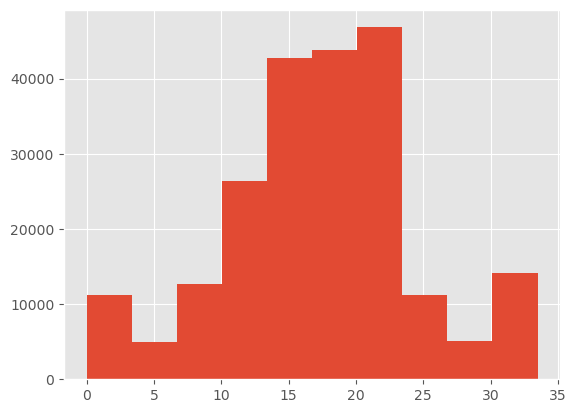

In [57]:
train['Time'] = train['Time'] / 3600
train['Time'].hist();

In [60]:
train['Time_Label'] = np.where(((train['Time'] >= 0) & (train['Time'] < 4)), 'Early_Morning',
                               np.where(((train['Time'] >= 4) & (train['Time'] < 10)), 'Morning',
                                       np.where(((train['Time'] >= 10) & (train['Time'] < 16)), 'Afternoon',
                                                np.where(((train['Time'] >= 16) & (train['Time'] < 22)), 'Night',
                                                         np.where(((train['Time'] >= 22) & (train['Time'] < 28)), 'Early_Morning', 'Morning')))))

In [64]:
test['Time_Label'] = np.where(((test['Time'] >= 33) & (test['Time'] < 34)), 'Morning', 
                              np.where(((test['Time'] >= 34) & (test['Time'] < 40)), 'Afternoon', 
                                       np.where(((test['Time'] >= 40) & (test['Time'] < 46)), 'Night', 'Eraly_Morning')))

In [61]:
train['Time_Label'].value_counts()

Night            81738
Afternoon        60465
Early_Morning    43238
Morning          33688
Name: Time_Label, dtype: int64

In [58]:
train['Time'].describe()

count    219129.000000
mean         17.327060
std           7.116763
min           0.000000
25%          13.314722
50%          17.552500
75%          21.533056
max          33.494444
Name: Time, dtype: float64

In [63]:
test['Time'] = test['Time'] / 3600
test['Time'].describe()

count    146087.000000
mean         40.177202
std           3.960563
min          33.494444
25%          36.860556
50%          40.136944
75%          43.372222
max          47.997222
Name: Time, dtype: float64

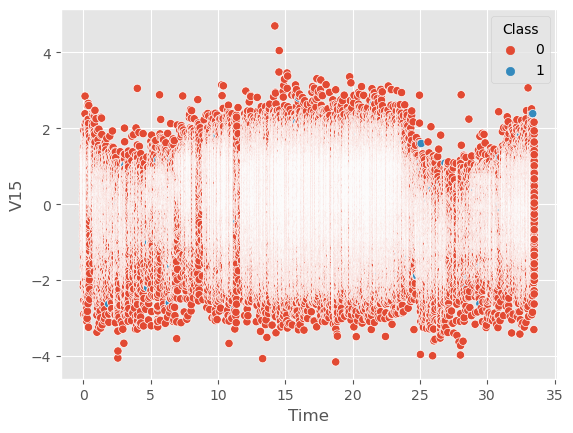

In [18]:
sns.scatterplot(x = 'Time', y = 'V15', data = train, hue = 'Class');

In [22]:
data_temp = train[train['Class'] == 1].reset_index(drop = True)

data_temp.head(10)

# plt.plot('Time', data = data_temp)
# plt.show();

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1681,0.212222,0.845797,-1.063059,0.120133,-0.312570,-0.056194,1.944391,-0.661839,0.582721,-0.992366,0.564202,1.766655,0.826499,-0.307964,0.393909,0.907691,-2.822682,1.055578,-1.061441,-2.138524,-0.569641,-0.430906,-0.919078,0.123612,-1.420935,-0.072559,0.293439,0.061270,0.006448,136.58,1
1,2039,0.256389,-1.808089,1.794735,-2.574549,-1.944174,-4.093440,-1.360198,-8.837694,-3.865127,4.847707,-1.826233,-1.552959,1.796523,-1.531125,-0.242458,0.926706,0.113577,-0.155949,0.393524,1.085312,1.570826,-2.662635,1.173416,-0.136751,0.739760,-0.692745,0.818293,0.745100,0.847648,2.00,1
2,2090,0.285556,-0.368027,1.492913,0.653399,0.164478,-1.043918,0.766250,-2.717382,-6.944203,-0.938474,-1.243744,1.555025,2.133379,0.125978,1.131705,0.057716,0.944642,-0.440088,0.049590,-0.878509,1.180116,-0.058687,1.185031,0.290564,0.528459,0.764303,-0.017768,0.110884,0.307835,0.12,1
3,3072,0.368889,1.990241,-0.185837,-1.039174,0.086245,0.107037,-0.409425,0.016713,-0.126446,0.279865,0.184726,1.090518,1.617814,0.906706,0.254738,-0.673049,0.193427,-0.771428,-0.214947,0.468155,-0.094906,-0.142725,-0.285513,0.263769,0.779628,-0.261358,0.255895,-0.074999,-0.059828,23.31,1
4,3780,0.399444,-0.738582,0.654464,0.652465,-0.139933,1.183689,-0.037131,0.638169,0.136502,-0.357541,-0.238928,1.039441,0.302428,-1.116929,0.651270,-0.295048,-0.421716,-0.456629,-0.037795,-0.826278,-0.314816,0.167918,0.563421,0.012614,-0.311213,0.105798,-0.252849,0.049231,0.108966,4.99,1
5,4473,0.434722,-0.052488,0.452235,0.597834,-1.036066,0.634370,-0.003599,0.423917,-0.061588,0.004540,-0.528083,-1.837332,-0.264823,0.893536,-0.006498,0.722872,1.132529,-1.366899,0.265849,0.428969,0.016501,-0.154343,-0.453740,-0.176718,-1.347568,-0.474435,0.834288,-0.074879,-0.023830,1.00,1
6,5136,0.476944,0.160589,0.786825,-0.724588,-0.750282,1.806480,0.934250,0.813886,0.023870,0.212364,-0.903241,0.974441,0.624075,0.116702,-1.391239,-0.394833,-0.637392,0.938174,-0.456530,-1.069392,-0.098123,0.221559,1.074745,-0.077353,-1.746858,-0.965505,-0.109738,-0.096479,-0.207858,5.80,1
7,5154,0.477500,-3.926970,1.591747,-3.651351,5.717551,3.759827,-2.266875,0.726805,-2.907956,-2.341475,-1.335848,2.906954,-2.067952,-0.452826,-6.569330,0.934333,1.571465,5.496659,2.558977,-0.281809,-0.738004,2.203823,-0.938597,-1.534221,-0.433038,-0.324845,0.409565,1.251167,-0.926380,0.77,1
8,5699,0.845833,-0.760997,0.756909,-0.178814,-3.217133,2.647633,2.961634,0.673867,0.570116,0.876679,-0.867483,-0.213593,0.141608,-0.310089,0.079070,0.633451,-0.120985,-1.182215,0.359537,0.270846,0.013869,-0.019683,0.173905,-0.310044,0.998894,0.204869,-0.817079,0.285749,0.068652,1.00,1
9,5733,0.860556,-1.127728,1.049167,-1.053558,-3.509578,0.446634,2.913674,1.004565,-1.852860,-0.099877,-2.039180,-0.104640,0.146959,-0.813447,0.976078,1.096701,0.008673,-0.845663,0.221515,0.074959,0.143465,-1.347635,1.078594,0.097118,0.932598,0.102219,-0.890189,0.356712,-0.104950,324.15,1


In [23]:
data_temp.describe()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.000000,469.0
mean,121243.722814,18.385665,-1.086640,0.360162,-0.729018,0.826276,0.072711,0.024195,-0.562112,-0.434633,0.295541,-0.330673,0.501366,-0.500703,0.104337,-0.596737,0.215408,-0.077345,0.231121,0.322761,-0.158610,0.181932,0.032385,-0.030467,-0.125792,-0.071228,0.118310,-0.147291,-0.001152,0.085422,108.391002,1.0
std,67374.938718,7.715779,3.202974,4.255666,2.759541,1.786987,2.164791,1.821944,2.465869,2.397392,1.695613,2.238858,1.369314,1.954465,1.171571,2.177261,1.008562,1.480743,2.391667,1.175975,0.968297,1.540108,1.259590,0.804570,1.125668,0.644059,0.589565,0.463175,0.748919,1.168934,376.603036,0.0
min,1681.000000,0.212222,-23.735245,-44.247914,-19.088980,-4.044858,-16.143833,-16.357833,-21.876190,-17.374875,-8.756951,-11.078394,-3.116825,-12.811547,-3.547486,-13.711105,-2.745817,-10.781414,-18.109933,-7.456060,-3.658399,-12.751490,-6.567663,-5.109636,-8.895803,-1.857683,-3.958591,-1.343868,-9.234767,-3.310876,0.000000,1.0
25%,63361.000000,14.140833,-1.827097,-0.219947,-1.679817,-0.104799,-0.784489,-0.907924,-0.918130,-0.359011,-0.615825,-1.146427,-0.438034,-1.124716,-0.692927,-1.121400,-0.394833,-0.617817,-0.404518,-0.166940,-0.801085,-0.204949,-0.246089,-0.480110,-0.217749,-0.439481,-0.228727,-0.418924,-0.041335,-0.044723,1.000000,1.0
50%,131980.000000,19.249167,-0.597535,0.588968,-0.251228,0.812230,0.015662,-0.124916,-0.269415,0.022567,0.028653,-0.369917,0.420047,-0.010684,0.011366,-0.084579,0.372802,0.122675,0.147059,0.331469,-0.202624,-0.042728,-0.034481,-0.009526,-0.046046,-0.041213,0.116638,-0.252230,0.036790,0.027947,8.760000,1.0
75%,183572.000000,22.934167,1.122965,1.637133,0.888828,1.505569,0.858477,0.664157,0.376847,0.446651,1.012628,0.146439,1.283389,0.634221,0.884935,0.602488,0.945750,0.737569,1.001344,0.992751,0.426517,0.244513,0.187923,0.490126,0.110160,0.385332,0.486712,0.092445,0.132959,0.131848,39.950000,1.0
max,219086.000000,33.492500,2.169813,9.275076,3.697068,8.918977,20.976643,7.363600,15.923791,14.073865,10.408025,11.663813,6.304578,5.406614,3.664370,3.917690,2.796549,5.834992,6.138931,2.933991,4.031429,13.585749,8.097728,3.066008,5.312675,1.135796,2.420944,2.658908,1.967485,23.263746,4471.960000,1.0


In [24]:
train.shape

(219129, 32)

In [25]:
test.shape

(146087, 31)

In [26]:
146087 / 219129

0.6666712301886104

In [31]:
data_temp.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1681,0.212222,0.845797,-1.063059,0.120133,-0.312570,-0.056194,1.944391,-0.661839,0.582721,-0.992366,0.564202,1.766655,0.826499,-0.307964,0.393909,0.907691,-2.822682,1.055578,-1.061441,-2.138524,-0.569641,-0.430906,-0.919078,0.123612,-1.420935,-0.072559,0.293439,0.061270,0.006448,136.58,1
1,2039,0.256389,-1.808089,1.794735,-2.574549,-1.944174,-4.093440,-1.360198,-8.837694,-3.865127,4.847707,-1.826233,-1.552959,1.796523,-1.531125,-0.242458,0.926706,0.113577,-0.155949,0.393524,1.085312,1.570826,-2.662635,1.173416,-0.136751,0.739760,-0.692745,0.818293,0.745100,0.847648,2.00,1
2,2090,0.285556,-0.368027,1.492913,0.653399,0.164478,-1.043918,0.766250,-2.717382,-6.944203,-0.938474,-1.243744,1.555025,2.133379,0.125978,1.131705,0.057716,0.944642,-0.440088,0.049590,-0.878509,1.180116,-0.058687,1.185031,0.290564,0.528459,0.764303,-0.017768,0.110884,0.307835,0.12,1
3,3072,0.368889,1.990241,-0.185837,-1.039174,0.086245,0.107037,-0.409425,0.016713,-0.126446,0.279865,0.184726,1.090518,1.617814,0.906706,0.254738,-0.673049,0.193427,-0.771428,-0.214947,0.468155,-0.094906,-0.142725,-0.285513,0.263769,0.779628,-0.261358,0.255895,-0.074999,-0.059828,23.31,1
4,3780,0.399444,-0.738582,0.654464,0.652465,-0.139933,1.183689,-0.037131,0.638169,0.136502,-0.357541,-0.238928,1.039441,0.302428,-1.116929,0.651270,-0.295048,-0.421716,-0.456629,-0.037795,-0.826278,-0.314816,0.167918,0.563421,0.012614,-0.311213,0.105798,-0.252849,0.049231,0.108966,4.99,1


<AxesSubplot: >

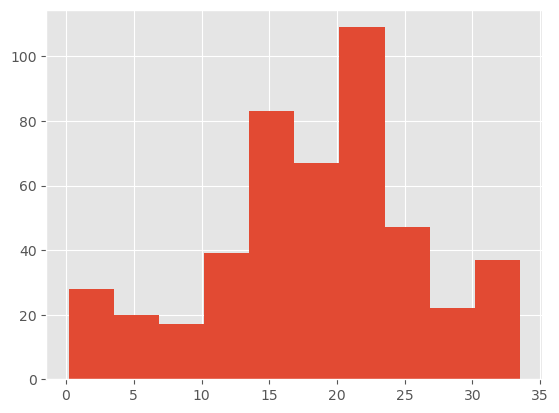

In [37]:
data_temp['Time'].hist()

In [38]:
data_temp['Time'].describe()

count    469.000000
mean      18.385665
std        7.715779
min        0.212222
25%       14.140833
50%       19.249167
75%       22.934167
max       33.492500
Name: Time, dtype: float64

# Looking at the first 6 hours 

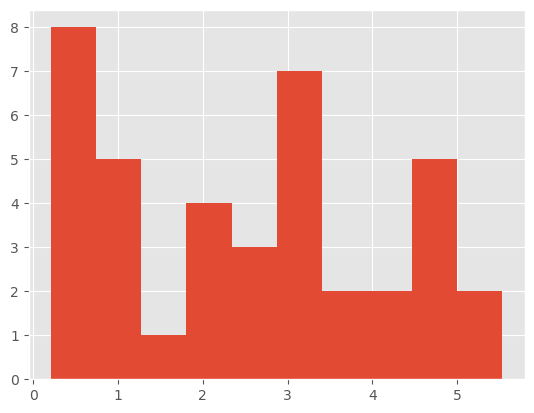

In [41]:
data_6 = train[train['Time'] < 6]
data_6_fraud = data_6[data_6['Class'] == 1]
data_6_fraud['Time'].hist();

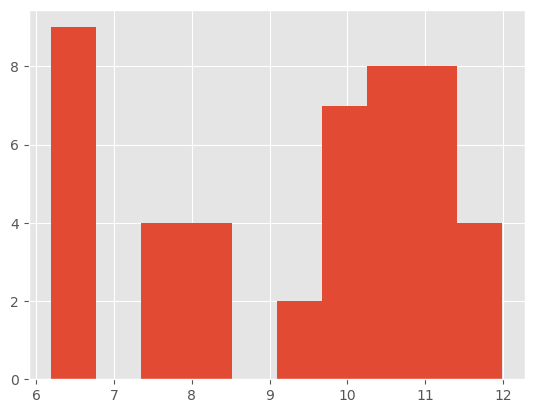

In [42]:
data_12 = train[(train['Time'] > 6) & (train['Time'] < 12)]
data_12_fraud = data_12[data_12['Class'] == 1]
data_12_fraud['Time'].hist();

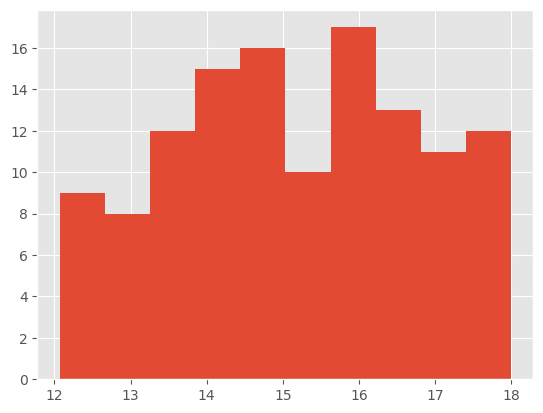

In [43]:
data_18 = train[(train['Time'] > 12) & (train['Time'] < 18)]
data_18_fraud = data_18[data_18['Class'] == 1]
data_18_fraud['Time'].hist();

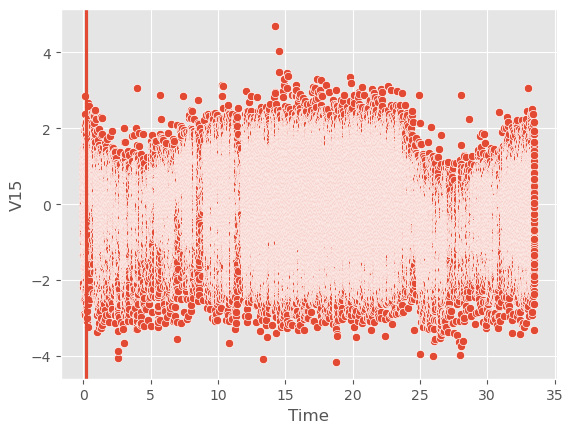

In [34]:
sns.scatterplot(x = 'Time', y = 'V15', data = train);
plt.axvline(x = 0.212222);
plt.axvline(x = 0.256389);
plt.axvline(x = 0.285556);

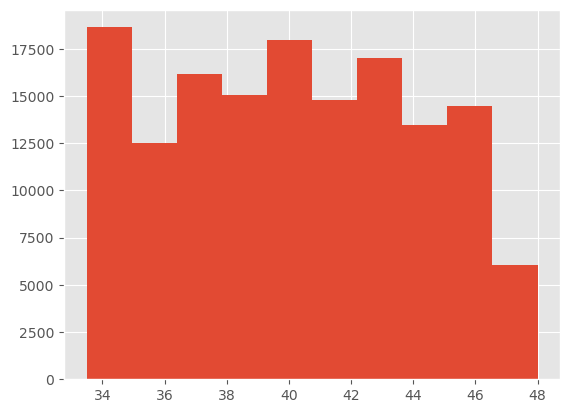

In [19]:
test['Time'] = test['Time'] / 3600
test['Time'].hist();

# XGBoost Modeling

In [16]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']
test = test.drop(columns = 'id', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'hist',
                               colsample_bytree = 0.7, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 7, 
                               min_child_weight = 10, 
                               n_estimators = 500, 
                               subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict_proba(X_test)[:, 1]
        XGB_pred_2 = XGB_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        XGB_cv_scores.append(roc_auc_score(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.8067141139487256


# LightGBM Modeling

In [17]:
scaler = MinMaxScaler()

lgb_cv_scores, lgb_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
        ## Scaling the data
#         X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
#         X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X.columns)
        
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 1000,
                                max_depth = 7,
                                learning_rate = 0.01,
                                num_leaves = 10,
                                lambda_l1 = 3,
                                lambda_l2 = 3,
                                bagging_fraction = 0.7,
                                feature_fraction = 0.7).fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        lgb_cv_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)

lgb_cv_score = np.mean(lgb_cv_scores)    
print('The average oof roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] 

In [18]:
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['Class'] = lgb_preds_test
submission.to_csv('lgb_submission.csv', index = False)

# CatBoost

In [19]:
cat_cv_scores, cat_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
        ## Scaling the data
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X.columns)
        
        ## Building the CatBoost model
        cat_md = CatBoostClassifier(iterations = 1000, 
                                    depth = 7,
                                    learning_rate = 0.01,
                                    rsm = 0.5,
                                    subsample = 0.9,
                                    l2_leaf_reg = 69,
                                    min_data_in_leaf = 20,
                                    random_strength = 0.175,
                                    random_seed = 836,
                                    task_type = 'CPU',
                                    bootstrap_type = 'Bernoulli',
                                    grow_policy = 'SymmetricTree',
                                    loss_function = 'Logloss',
                                    verbose = False).fit(X_train, Y_train)
        cat_imp.append(cat_md.feature_importances_)
            
        ## Predicting on X_test and test
        cat_pred_1 = cat_md.predict_proba(X_test)[:, 1]
        cat_pred_2 = cat_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        cat_cv_scores.append(roc_auc_score(Y_test, cat_pred_1))
        preds.append(cat_pred_2)
        
cat_cv_score = np.mean(cat_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', cat_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.7477153684335462


In [ ]:
cat_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['Class'] = cat_preds_test
submission.to_csv('CatBoost_submission.csv', index = False)

# Adding Time Feature

In [29]:
train['Time'] = train['Time'] / 3600
test['Time'] = test['Time'] / 3600

train['Time_Label'] = np.where(((train['Time'] >= 0) & (train['Time'] < 4)), 'Early_Morning',
                               np.where(((train['Time'] >= 4) & (train['Time'] < 10)), 'Morning',
                                       np.where(((train['Time'] >= 10) & (train['Time'] < 16)), 'Afternoon',
                                                np.where(((train['Time'] >= 16) & (train['Time'] < 22)), 'Night',
                                                         np.where(((train['Time'] >= 22) & (train['Time'] < 28)), 'Early_Morning', 'Morning')))))

test['Time_Label'] = np.where(((test['Time'] >= 33) & (test['Time'] < 34)), 'Morning', 
                              np.where(((test['Time'] >= 34) & (test['Time'] < 40)), 'Afternoon', 
                                       np.where(((test['Time'] >= 40) & (test['Time'] < 46)), 'Night', 'Early_Morning')))

train_dummies = pd.get_dummies(train['Time_Label'])
test_dummies = pd.get_dummies(test['Time_Label'])

train = pd.concat([train, train_dummies], axis = 1)
train = train.drop(columns = ['Time', 'Time_Label', 'Morning', 'Afternoon', 'Night'], axis = 1)

test = pd.concat([test, test_dummies], axis = 1)
test = test.drop(columns = ['Time', 'Time_Label', 'Morning', 'Afternoon', 'Night'], axis = 1)

In [30]:
train.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Early_Morning
0,0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,0.742144,0.108782,-1.070243,-0.234910,-1.099360,0.502467,0.169318,0.065688,-0.306957,-0.323800,0.103348,-0.292969,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0,1
1,1,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,-0.109948,0.908773,0.836798,-0.056580,-0.120990,-0.144028,-0.039582,1.653057,-0.253599,-0.814354,0.716784,0.065717,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0,1
2,2,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,-0.042027,-0.818383,-0.376512,-0.226546,-0.552869,-0.886466,-0.180890,0.230286,0.590579,-0.321590,-0.433959,-0.021375,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0,1
3,3,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,0.885838,-0.007527,0.637441,0.676960,-1.504823,0.554039,-0.824356,-0.527267,-0.095838,-0.312519,0.642659,-0.340089,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0,1
4,4,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,0.692665,-0.097495,1.338869,1.391399,-0.128167,-0.081836,0.100548,-0.338937,0.090864,-0.423645,-0.731939,-0.203628,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0,1


In [31]:
test.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Early_Morning
0,219129,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,-0.230126,0.220610,1.058325,-0.723363,-0.619241,-2.243711,-0.271429,2.007845,1.213534,0.282344,0.579121,0.067367,0.241708,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944,29.95,0
1,219130,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,1.068183,0.483337,0.274519,-0.346514,-0.409519,-0.564673,-0.143855,1.334855,0.160901,-0.087356,-0.066264,0.441788,0.543278,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690,163.50,0
2,219131,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,-1.177858,1.626352,0.601148,-0.041610,0.432748,-0.527684,-0.543665,0.043896,0.058472,0.622667,0.010671,-0.366906,-0.131527,0.086623,0.291375,0.739087,-0.543006,-0.297813,0.043699,-0.037855,16.00,0
3,219132,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,2.079398,-1.225592,-0.869368,1.647638,1.138026,-0.258468,-0.361765,-1.253326,0.099479,-0.587702,1.207085,-0.049136,-0.080115,-0.010732,-0.038550,0.656830,0.343470,-0.627529,-0.024338,-0.036143,120.98,0
4,219133,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,-0.281749,-0.341879,0.471628,0.637604,-0.592416,0.331702,-1.451799,0.096467,-0.853439,-0.462060,-0.267098,0.391627,0.083389,-0.306918,0.247822,-0.391799,-0.790716,-0.025706,0.330758,0.335537,1.98,0


# XGBoost

In [32]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']
test = test.drop(columns = 'id', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'hist',
                               colsample_bytree = 0.7, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 7, 
                               min_child_weight = 10, 
                               n_estimators = 500, 
                               subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict_proba(X_test)[:, 1]
        XGB_pred_2 = XGB_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        XGB_cv_scores.append(roc_auc_score(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.8078137912787277


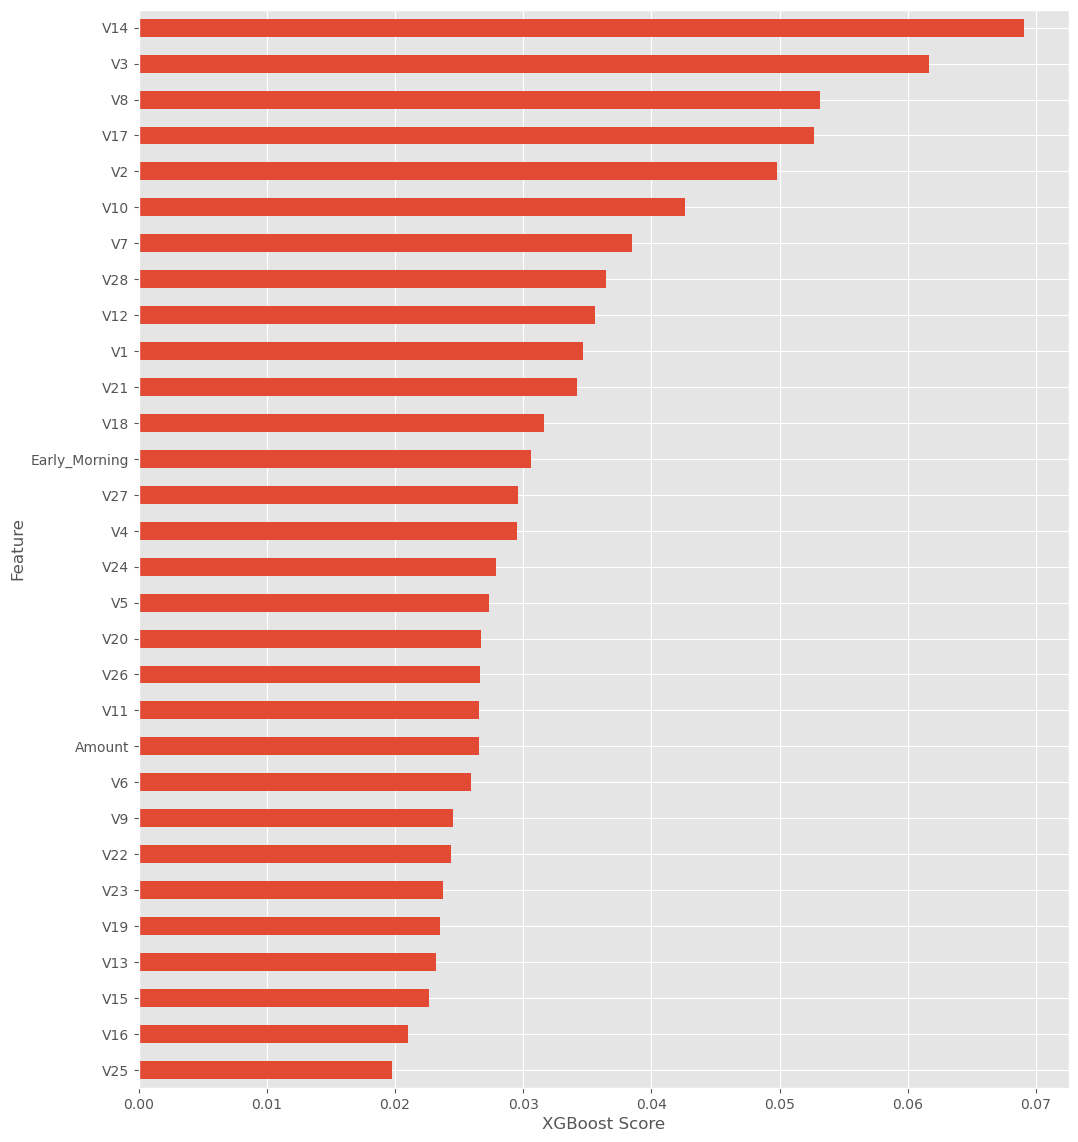

In [33]:
plt.figure(figsize = (12, 14))
pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();

In [35]:
xgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['Class'] = xgb_preds_test
submission.to_csv('xgb_time_FE_1_submission.csv', index = False)

# LightGBM

In [37]:
# scaler = MinMaxScaler()

lgb_cv_scores, lgb_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
        ## Scaling the data
#         X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
#         X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X.columns)
        
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 1000,
                                max_depth = 7,
                                learning_rate = 0.01,
                                num_leaves = 10,
                                lambda_l1 = 3,
                                lambda_l2 = 3,
                                bagging_fraction = 0.7,
                                feature_fraction = 0.7).fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        lgb_cv_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)

lgb_cv_score = np.mean(lgb_cv_scores)    
print('The average oof roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] 

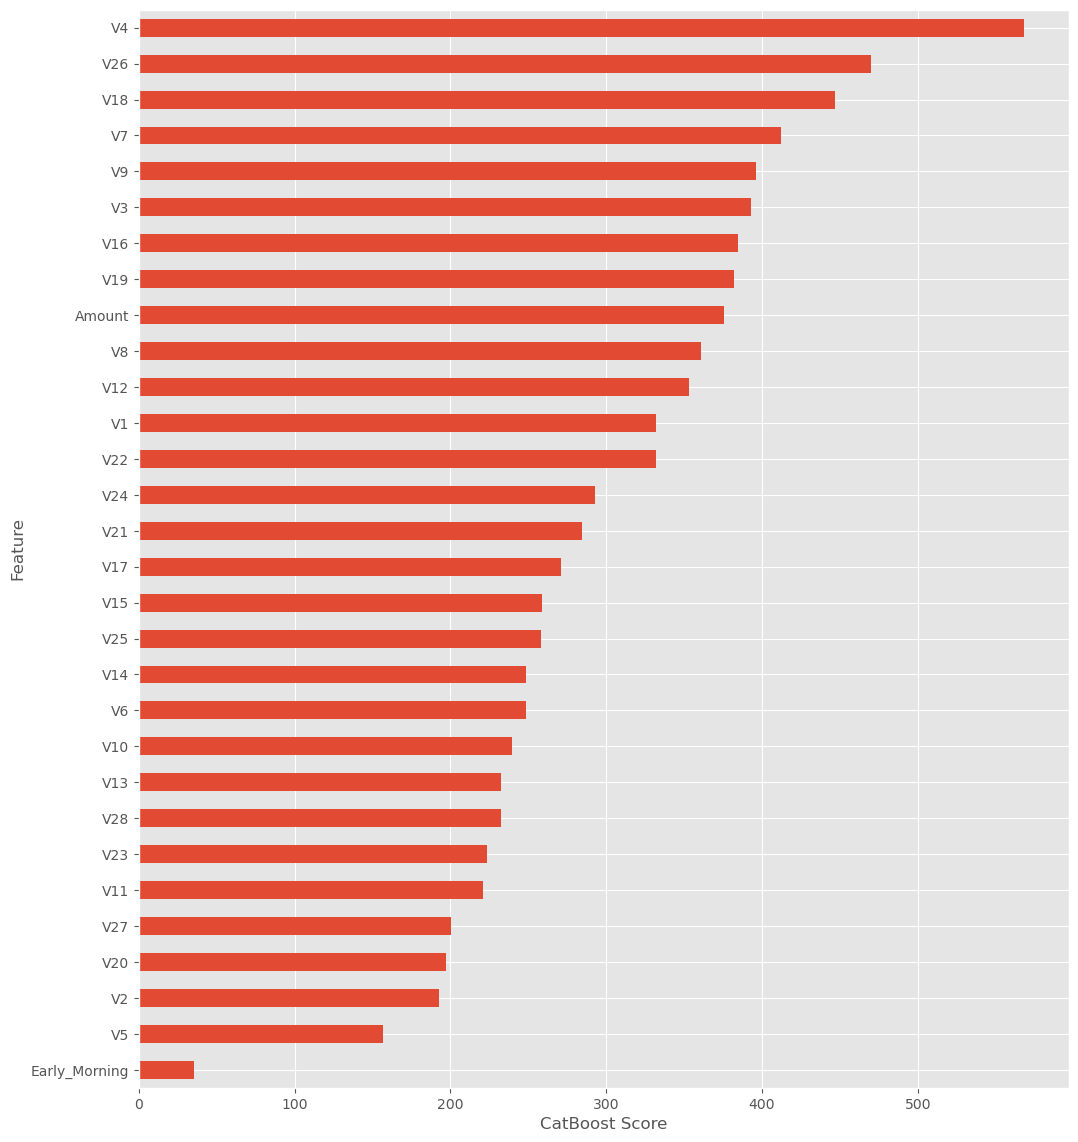

In [38]:
plt.figure(figsize = (12, 14))
pd.DataFrame(lgb_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('CatBoost Score')
plt.ylabel('Feature')
plt.show();

In [39]:
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['Class'] = lgb_preds_test
submission.to_csv('lgb_time_FE_1_submission.csv', index = False)